# DD2417 - Miniproject, RNN word predictions


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import re
import numpy as np
import time

from torch.utils.data import Dataset, DataLoader, TensorDataset

from tqdm import tqdm
import matplotlib.pyplot as plt
import time
from collections import deque

from sklearn.model_selection import GridSearchCV
import random


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [ ]:

class TextProcessor:
    def __init__(self, file_path, sequence_length):
        self.vocab = []
        self._i2w = {}
        self._w2i = {}

        self.file_path = file_path
        self.unprocessed_text = self._load_file(self.file_path)
        self.text = self.process_text(self.unprocessed_text)
        self.create_vocab(self.text)

        self.sequence_length = sequence_length
        self._vocablength = len(self.vocab)
        print(self._vocablength)

    def _load_file(self, file_path):
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            return file.read().lower()

    def _clean_text(self, text):
        text = re.sub(r"[^a-zA-Z',.!]", ' ', text)
        return text

    def _tokenize(self, text):
        tokens = re.findall(r"\b\w+(?:'\w+)?\b|[.!,?]", text)
        return tokens

    def process_text(self, text):
        cleaned_text = self._clean_text(text)
        tokens = self._tokenize(cleaned_text)
        return tokens

    def create_vocab(self, text):
        # Add an unknown word
        self.vocab.append('<UNK>')
        self._i2w[0] = '<UNK>'
        self._w2i['<UNK>'] = 0

        idx = 1
        for i, word in enumerate(text):
            if word not in self.vocab:
                self.vocab.append(word)
                self._i2w[idx] = word
                self._w2i[word] = idx
                idx += 1

    def text_to_indices(self, text):
        indices = []
        for word in text:
            if word in self._w2i:
                indices.append(self._w2i[word])
            else:
                indices.append(0)
        return indices

    def generate_sequences(self):
        sequences = []
        for i in range(0, len(self.text) - self.sequence_length):
            sequences.append(self.text_to_indices(self.text[i:i + self.sequence_length]))
        return np.array(sequences)

    def generate_input_target_sequences(self):
        sequences = self.generate_sequences()
        inputs = sequences[:, :-1]  # Exclude the last word from inputs
        targets = sequences[:, -1]   # Exclude the first word from targets
        return inputs, targets

    def generate_dataloader(self, batch_size):
        inputs, targets = self.generate_input_target_sequences()

        # Convert numpy arrays to PyTorch tensors
        inputs = torch.LongTensor(inputs)
        targets = torch.LongTensor(targets)

        # Create DataLoader for batching and shuffling data
        dataset = TensorDataset(inputs, targets)
        train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        return train_loader




In [ ]:

class DeepNetwork(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, hidden_size=256, num_layers=2, drop_out=0.0):
        super(DeepNetwork, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_size, num_layers=num_layers, batch_first=True, dropout=drop_out)
        self.final = nn.Linear(hidden_size, vocab_size)

    def forward(self, t, hidden):
        embeddings = self.embedding(t)
        out, hidden = self.rnn(embeddings, hidden)
        out = self.final(out[:, -1, :])
        return out, hidden



In [ ]:
class Train:
    def __init__(self, train_filepath, test_filepath, sequence_length=10, embedding_dim=100, hidden_size=256,
                 batch_size=64, learning_rate=1e-3, num_epochs=50,
                 drop_out=0.0, num_layers=2):
        self.train_filepath = train_filepath
        self.test_filepath = test_filepath
        self.sequence_length = sequence_length
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.drop_out = drop_out
        self.num_layers = num_layers

        self.trainTP = TextProcessor(self.train_filepath, self.sequence_length)
        self.dataloader = self.trainTP.generate_dataloader(self.batch_size)

        self.eval_text = self.trainTP.process_text(self.trainTP._load_file(self.test_filepath))
        self.eval_text = self.trainTP.text_to_indices(self.eval_text)

        self.vocab_size = self.trainTP._vocablength

        self.model = DeepNetwork(self.vocab_size, self.embedding_dim, self.hidden_size, self.num_layers, self.drop_out).to(device)

        self.loss_func = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

        self.neighbours = 100


    def train_network(self, use_tqdm=True):
        self.losses = []
        self.accuracies = []
        self.model.train()
        self.acc_epoch = []
        self.accuracies_words = []
        start_time = time.time()  # Record the start time

        for epoch in range(self.num_epochs):
            running_loss = 0.0
            if use_tqdm:
                progress_bar = tqdm(self.dataloader, desc=f"Epoch {epoch+1}/{self.num_epochs}")
            else:
                progress_bar = self.dataloader

            correct_predictions = 0
            total_predictions = 0
            hidden = torch.zeros(self.num_layers, self.batch_size, self.hidden_size).to(device)
            for inputs, targets in progress_bar:
                if inputs.shape[0] != self.batch_size:
                    break
                inputs, targets = inputs.to(device), targets.to(device)

                self.optimizer.zero_grad()

                outputs, _ = self.model(inputs, hidden)

                outputs = outputs.view(-1, self.vocab_size)
                targets = targets.view(-1)
                loss = self.loss_func(outputs, targets)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()

                if use_tqdm:
                    progress_bar.set_postfix(loss=running_loss/len(self.dataloader))

                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == targets.view(-1)).sum().item()
                total_predictions += targets.size(0)

            acc, acc_words = self.evaluate_text(self.neighbours)
            self.accuracies.append(acc)
            self.accuracies_words.append(acc_words)
            self.model.train()

            epoch_loss = running_loss/len(self.dataloader)
            self.losses.append(epoch_loss)

            epoch_accuracy = correct_predictions / total_predictions
            self.acc_epoch.append(epoch_accuracy)

            print(f"Epoch {epoch+1}/{self.num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

        end_time = time.time()
        elapsed_time = end_time - start_time
        print(elapsed_time)

        return


    def _generate_words(self, input_indices, neighbours, hidden):
        input_tensor = torch.LongTensor([input_indices]).to(device)
        with torch.no_grad():
            output, hidden = self.model(input_tensor, hidden)

        output = output.squeeze(0)

        probabilities = F.softmax(output, dim=0).cpu().numpy()

        top_indices = np.argsort(probabilities)[-neighbours:][::-1]
        top_words = [self.trainTP._i2w[idx] for idx in top_indices]
        top_probs = probabilities[top_indices]

        return top_indices, top_words, hidden


    def evaluate_text(self, neighbours=100, nr_of_suggestions=5):
        self.model.eval()
        start = self.eval_text[0]
        saved_keystrokes = 0
        total_keystrokes = 0

        found_words = 0
        total_words = 0

        input_indices = deque([start], maxlen=self.sequence_length-1)

        for index in self.eval_text[1:]:
            hidden = torch.zeros(self.num_layers, 1, self.hidden_size).to(device)
            top_indices, top_words, hidden = self._generate_words(input_indices, neighbours, hidden)

            fw, sk = self.evaluate_options(self.trainTP._i2w[index], top_words, nr_of_suggestions)

            saved_keystrokes += sk
            found_words += fw

            total_words += 1
            total_keystrokes += len(self.trainTP._i2w[index])
            input_indices.append(index)

        print(f'Saved keystroke percentage: {100*saved_keystrokes/total_keystrokes:.2f}%')
        print(f'Found words percentage: {100*found_words/total_words:.2f}%')
        return saved_keystrokes/total_keystrokes, found_words/total_words


    def evaluate_options(self, target_word, options, nr_of_suggestions):
        """Target word is the next word, options is a list of the k most probable words according to the model
        Outputs found_word which is 1 if the target_word is in options else 0
        Outputs saved_keystrokes which is the amount of saved keystrokes, 0 if target_word not in options"""
        if target_word in options:
            if target_word in options[:nr_of_suggestions]:
                found_word = 1
                saved_keystrokes = len(target_word)
                return found_word, saved_keystrokes
            for len_of_word in range(len(target_word)+1):
                options = [word for word in options if word[:len_of_word] == target_word[:len_of_word]]
                if target_word in options[:nr_of_suggestions]:
                    found_word = 1
                    saved_keystrokes = len(target_word) - len_of_word
                    return found_word, saved_keystrokes
            return (0, 0)

        else:
            found_word = 0
            saved_keystrokes = 0
            return found_word, saved_keystrokes


    def save_model(self, file_path):
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'w2i': self.trainTP._w2i,
            'i2w': self.trainTP._i2w,
            'embedding_dim': self.embedding_dim,
            'hidden_size': self.hidden_size,
            'drop_out': self.drop_out,
            'num_layers': self.num_layers,
            'vocab_size': self.vocab_size,
            'sequence_length': self.sequence_length,
            'losses': self.losses,
            'accuracies': self.accuracies,
            'epoch_acc': self.acc_epoch,
            'accuracies_words': self.accuracies_words,
            'eval_text': self.eval_text
        }, file_path)
        print(f"Model saved to {file_path}")



In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 45
set_seed(seed)

In [ ]:
sequence_length = 8
embedding_dim = 200
hidden_size = 128
batch_size = 64
learning_rate = 0.001
drop = 0.0
num_layers = 2


train = Train(train_filepath='train_file.txt', test_filepath='test_file.txt',  sequence_length=sequence_length, embedding_dim=embedding_dim, hidden_size=hidden_size,
              batch_size=batch_size, learning_rate=learning_rate, num_epochs=6, drop_out=drop, num_layers=num_layers)
train.train_network(use_tqdm=True)
print('\n neighbours: 5, nr of suggestions:5')
train.evaluate_text(neighbours=5, nr_of_suggestions=5)

print('\n neighbours: 20, nr of suggestions:5')
train.evaluate_text(neighbours=20, nr_of_suggestions=5)

print('\n neighbours: 50, nr of suggestions:5')
train.evaluate_text(neighbours=50, nr_of_suggestions=5)

print('\n neighbours: 100, nr of suggestions:5')
train.evaluate_text(neighbours=100, nr_of_suggestions=5)

print('\n neighbours: 100, nr of suggestions:10')
train.evaluate_text(neighbours=100, nr_of_suggestions=5)

train.save_model('model.pth')

22977


Epoch 1/6: 100%|█████████▉| 18852/18853 [02:07<00:00, 147.67it/s, loss=5.24]


Saved keystroke percentage: 52.22%
Found words percentage: 75.36%
Epoch 1/6, Loss: 5.2450, Accuracy: 0.1779


Epoch 2/6: 100%|█████████▉| 18852/18853 [02:07<00:00, 148.00it/s, loss=4.79]


Saved keystroke percentage: 53.89%
Found words percentage: 76.12%
Epoch 2/6, Loss: 4.7887, Accuracy: 0.2079


Epoch 3/6: 100%|█████████▉| 18852/18853 [02:07<00:00, 147.81it/s, loss=4.64]


Saved keystroke percentage: 54.46%
Found words percentage: 76.49%
Epoch 3/6, Loss: 4.6376, Accuracy: 0.2182


Epoch 4/6: 100%|█████████▉| 18852/18853 [02:07<00:00, 147.80it/s, loss=4.53]


Saved keystroke percentage: 54.77%
Found words percentage: 76.71%
Epoch 4/6, Loss: 4.5309, Accuracy: 0.2249


Epoch 5/6: 100%|█████████▉| 18852/18853 [02:07<00:00, 147.96it/s, loss=4.45]


Saved keystroke percentage: 54.65%
Found words percentage: 76.58%
Epoch 5/6, Loss: 4.4455, Accuracy: 0.2299


Epoch 6/6: 100%|█████████▉| 18852/18853 [02:07<00:00, 147.79it/s, loss=4.37]


Saved keystroke percentage: 54.61%
Found words percentage: 76.44%
Epoch 6/6, Loss: 4.3740, Accuracy: 0.2347
1294.752946138382

 neighbours: 5, nr of suggestions:5
Saved keystroke percentage: 28.40%
Found words percentage: 41.95%

 neighbours: 20, nr of suggestions:5
Saved keystroke percentage: 40.51%
Found words percentage: 59.23%

 neighbours: 50, nr of suggestions:5
Saved keystroke percentage: 48.91%
Found words percentage: 69.67%

 neighbours: 100, nr of suggestions:5
Saved keystroke percentage: 54.61%
Found words percentage: 76.44%

 neighbours: 100, nr of suggestions:10
Saved keystroke percentage: 54.61%
Found words percentage: 76.44%
Model saved to model.pth


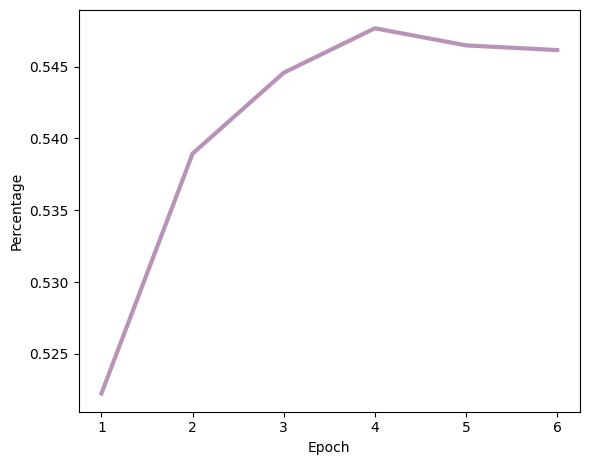

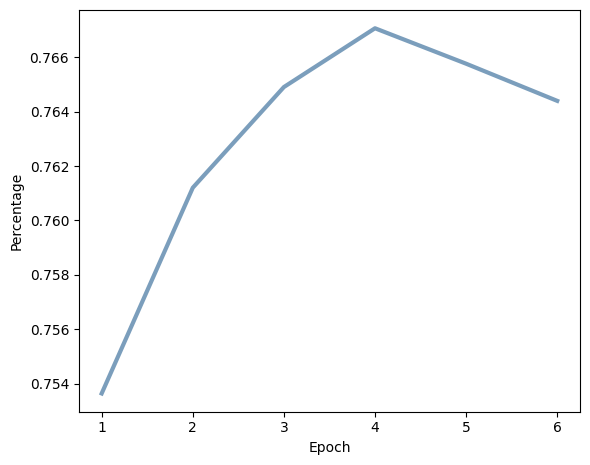

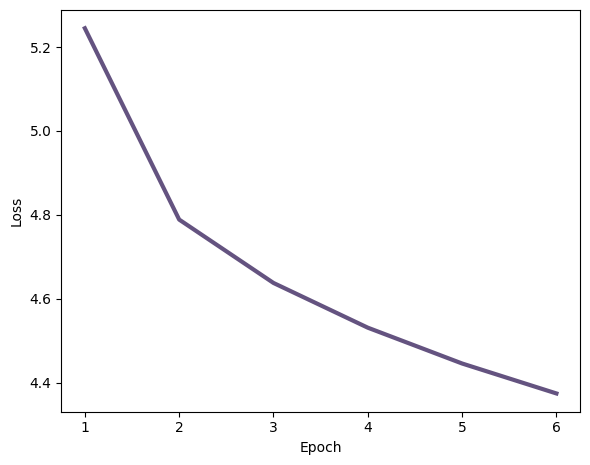

In [ ]:

plt.figure(figsize=(6, 4.75))  # Set the size of the figure window (width, height) in inches
epochs = range(1, len(train.accuracies) + 1)
plt.plot(epochs, train.accuracies, color='#b892b7', linewidth=3)
plt.xlabel('Epoch')
plt.ylabel('Percentage')
plt.tight_layout()
plt.savefig('train_accuracies_saved_keys.png', dpi=600)
plt.show()

# Second plot
plt.figure(figsize=(6, 4.75))  # Set the size of the figure window (width, height) in inches
epochs_words = range(1, len(train.accuracies_words) + 1)
plt.plot(epochs_words, train.accuracies_words, color='#7b9ebc', linewidth=3)
plt.xlabel('Epoch')
plt.ylabel('Percentage')
plt.tight_layout()
plt.savefig('train_accuracies_saved_words.png', dpi=600)
plt.show()

# Third plot
plt.figure(figsize=(6, 4.75))  # Set the size of the figure window (width, height) in inches
epochs_losses = range(1, len(train.losses) + 1)
plt.plot(epochs_losses, train.losses, color='#645380', linewidth=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.savefig('train_losses.png', dpi=600)
plt.show()

In [ ]:
##Perform hyperparameter search

import itertools

# Define the ranges for the hyperparameters
sequence_lengths = [8, 16]
embedding_dims = [100, 200]
hidden_sizes = [128, 256]
batch_sizes = [64]
learning_rates = [1e-3, 1e-4]
drop_rates = [0.3, 0.0]
num_layers_options = [2, 4]
model_types = ['gru']


best = {}
i = 0

# Track the best hyperparameters and corresponding performance
best_hyperparams = None
best_performance = -float('inf')

# Iterate over all combinations of hyperparameters
for sequence_length, embedding_dim, hidden_size, batch_size, learning_rate, drop, num_layers, m_type in itertools.product(
    sequence_lengths, embedding_dims, hidden_sizes, batch_sizes, learning_rates, drop_rates, num_layers_options, model_types):

    # Initialize the Train class with the current set of hyperparameters
    train = Train(train_filepath='train_file.txt', test_filepath='test_file.txt',
                  sequence_length=sequence_length, embedding_dim=embedding_dim, hidden_size=hidden_size,
                  batch_size=batch_size, learning_rate=learning_rate, num_epochs=20,
                  drop=drop, num_layers=num_layers, m_type=m_type)

    # Train the model
    train.train_network(use_tqdm=False)

    # Evaluate the model
    performance = train.evaluate_text()

    params = {'sequence_length': sequence_length,
            'embedding_dim': embedding_dim,
            'hidden_size': hidden_size,
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'drop': drop,
            'num_layers': num_layers,
            'm_type': m_type
            }
    best[i] = [performance, params]

    print("Best Hyperparameters:")
    for param, value in params.items():
        print(f"{param}: {value}")
    print(f"Best Performance: {performance}")
    print('\n')

    i += 1

    # Check if the current performance is better than the best performance seen so far
    if performance > best_performance:
        best_performance = performance
        best_hyperparams = {
            'sequence_length': sequence_length,
            'embedding_dim': embedding_dim,
            'hidden_size': hidden_size,
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'drop': drop,
            'num_layers': num_layers,
            'm_type': m_type
        }

# Print the best hyperparameters and the corresponding performance
print("Best Hyperparameters:")
for param, value in best_hyperparams.items():
    print(f"{param}: {value}")
print(f"Best Performance: {best_performance}")


<built-in method size of Tensor object at 0x7f9ab542bd30>


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)